In [1]:
import sys
sys.path.append('../../../')
sys.path.append('/home/sheida.rahnamai/GIT/HDN/')
import torch
import numpy as np
from sklearn.cluster import HDBSCAN
from tqdm import tqdm
# from lib.dataloader import CustomTestDataset
import tifffile as tiff
import os
from sklearn.cluster import KMeans

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

dist_metric = ['cosine']

num_clusters = 4
patch_size = (64,64)
mask_size = 5
label_size = 5
n_channel = 32
hierarchy_level = 3

In [3]:
data_dir = "/group/jug/Sheida/pancreatic beta cells/download/"

One_test_image = ['high_c4']

# Load test image
test_img_path = os.path.join(data_dir, One_test_image[0], f"{One_test_image[0]}_source.tif")
test_images = tiff.imread(test_img_path)

# Print loaded test images paths
print("Test image loaded from path:")
print(test_img_path)

# Load test ground truth images
test_gt_path = os.path.join(data_dir, One_test_image[0], f"{One_test_image[0]}_gt.tif")
test_ground_truth_image = tiff.imread(test_gt_path)

Test image loaded from path:
/group/jug/Sheida/pancreatic beta cells/download/high_c4/high_c4_source.tif


In [4]:
def count_label_pixels(ground_truth):
    # Get unique labels and their counts
    unique_labels, counts = np.unique(ground_truth, return_counts=True)
    
    # Create a dictionary to store label-wise pixel counts
    label_pixel_counts = dict(zip(unique_labels, counts))
    
    return label_pixel_counts

In [5]:
label_pixel_counts = count_label_pixels(test_ground_truth_image)
print(f"Label-wise pixel counts:{label_pixel_counts}")

Label-wise pixel counts:{-1: 409001638, 0: 107710351, 1: 25910981, 2: 36936035, 3: 23104175}


In [6]:
def select_random_pixels_within_range(ground_truth, labels, pixels_per_class, x_range, y_range, z_range):
    selected_pixels = {}

    for label in labels:
        # Get the coordinates where ground truth equals the label
        coords = np.argwhere(ground_truth == label)
        
        # Filter coordinates based on the specified range
        x_in_range = (coords[:, 2] >= x_range[0]) & (coords[:, 2] <= x_range[1])
        y_in_range = (coords[:, 1] >= y_range[0]) & (coords[:, 1] <= y_range[1])
        z_in_range = (coords[:, 0] >= z_range[0]) & (coords[:, 0] <= z_range[1])
        
        # Keep only the coordinates that satisfy all range conditions
        filtered_coords = coords[z_in_range & y_in_range & x_in_range]
        
        # Check if there are enough pixels for the current label after filtering
        if len(filtered_coords) < pixels_per_class:
            raise ValueError(f"Not enough pixels for label {label} within the specified range. Found {len(filtered_coords)}, required {pixels_per_class}")
        
        # Randomly select pixels_per_class coordinates from filtered_coords
        chosen_indices = np.random.choice(len(filtered_coords), pixels_per_class, replace=False)
        chosen_coords = filtered_coords[chosen_indices]
        
        # Store selected coordinates for the label
        selected_pixels[label] = chosen_coords

    return selected_pixels


In [7]:
labels_of_interest = [0, 1, 2, 3]
z, y, x = test_images.shape
x_range = (32, x - 32)
y_range = (32, y - 32)
z_range = (0, z - 1)

In [8]:
# selected_pixel_coords = select_random_pixels_within_range(test_ground_truth_image, labels_of_interest, pixels_per_class=256, x_range=x_range, y_range=y_range, z_range=z_range)

In [9]:
import pickle

def save_as_pickle(selected_pixel_coords, filename):
    with open(filename, 'wb') as f:
        pickle.dump(selected_pixel_coords, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    
    return data
# Usage
# save_as_pickle(selected_pixel_coords, 'selected_pixel_coords.pkl')
selected_pixel_coords = load_pickle('selected_pixel_coords.pkl')

In [10]:
for label, coords in selected_pixel_coords.items():
    print(f"Label {label}: {coords}")

Label 0: [[ 753  217  399]
 [ 588  418  440]
 [ 446   76  810]
 [ 344  307  929]
 [ 574  228  687]
 [ 688  442  985]
 [ 848  394  464]
 [ 575  194  302]
 [ 659  308  186]
 [ 883  404  615]
 [ 314  423  471]
 [ 374   99  670]
 [ 839  315  877]
 [ 714  286   99]
 [ 676  102  617]
 [ 550  417  389]
 [ 760  330  623]
 [ 606  436  479]
 [ 654  173  720]
 [ 315  137  447]
 [ 372  247  897]
 [ 686  218  731]
 [ 833  285   97]
 [ 403  151  414]
 [ 805  221  570]
 [ 481  500  541]
 [ 525  167  625]
 [ 835  394  559]
 [ 196  228  897]
 [ 737  300  730]
 [ 438  191  944]
 [ 589  363  427]
 [ 490  244  887]
 [ 363  255  241]
 [ 651  435  277]
 [ 796  203  277]
 [ 785  194  441]
 [ 208  155 1011]
 [ 472  175  630]
 [ 339  232  470]
 [ 429  204  954]
 [ 893  390  407]
 [ 756  229  682]
 [ 325  285  371]
 [ 272  351  950]
 [ 860  343  878]
 [ 584  170  820]
 [ 466  238  737]
 [ 857  254  149]
 [ 330  360  852]
 [ 780  264  537]
 [ 539  380  408]
 [ 548  135  785]
 [ 410   85  695]
 [ 726  262  153]
 

In [11]:
def extract_patches(image, coords, patch_size=(64,64)):
    half_size_y = patch_size[0] // 2
    half_size_x = patch_size[1] // 2
    patches = []

    # Get the shape of the image
    _, y_max, x_max = image.shape

    for coord in coords:
        z, y, x = coord

        # Calculate the boundaries of the patch
        x_start = max(0, x - half_size_x)
        x_end = min(x_max, x + half_size_x)
        y_start = max(0, y - half_size_y)
        y_end = min(y_max, y + half_size_y)

        
        # Extract the patch from the image
        patch = image[z, y_start:y_end, x_start:x_end]
        
        # Check if the patch is the required size, otherwise pad with zeros
        if patch.shape != patch_size:
            print("something is wrong")

        
        # Store the patch
        patches.append(patch)

    return np.array(patches)

In [12]:
all_patches_tensors = []

for label, coords in selected_pixel_coords.items():
    patches = extract_patches(test_images, coords, patch_size=patch_size)
    patches_tensor = torch.tensor(patches, dtype=torch.float32).unsqueeze(1)
    print(f"Patches for label {label}: {patches_tensor.shape}")  # The shape should be (256, 64, 64)
    all_patches_tensors.append(patches_tensor)

combined_tensor = torch.stack(all_patches_tensors, dim=0).reshape(8, 128, 1, 64, 64)
print(combined_tensor.shape)

Patches for label 0: torch.Size([256, 1, 64, 64])
Patches for label 1: torch.Size([256, 1, 64, 64])
Patches for label 2: torch.Size([256, 1, 64, 64])
Patches for label 3: torch.Size([256, 1, 64, 64])
torch.Size([8, 128, 1, 64, 64])


In [13]:
model_dir = "/group/jug/Sheida/HVAE/2D/"
model_versions = ['5x5_5x5', '5x5_3x3', '3x3_3x3', '5x5_1x1', '3x3_1x1', '1x1_1x1']
batch_size = 128
for model_v in model_versions:
    model = torch.load(model_dir+'supervised_'+str(model_v)+"/model/2D_HVAE_best_vae.net")
    data_mean = model.data_mean
    data_std = model.data_std
    model.mode_pred = True
    model.eval()
    device = model.device
    print(f"Processing 1024 pixels with model version supervised {model_v}")
    index = 0 
    all_mus = np.zeros((1024, 43008), dtype=np.float16)
    with torch.no_grad():
        for batch in tqdm(combined_tensor):
            batch = batch.to(device)
            batch = (batch - data_mean) / data_std
            output = model(batch)
            mu_test = torch.cat([output["mu"][i].reshape(batch_size, -1) for i in range(hierarchy_level)], dim=1)
            mu_test = np.array(mu_test.cpu().numpy())
            all_mus[index:index+batch_size] = mu_test
            index += batch_size

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(all_mus)
    cluster_labels = cluster_labels.reshape(4, 256)
    tiff.imwrite(f"{model_dir}supervised_{model_v}/1000pixels.tif", cluster_labels)

Processing 1024 pixels with model version supervised 5x5_5x5


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


Processing 1024 pixels with model version supervised 5x5_3x3


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.37it/s]


Processing 1024 pixels with model version supervised 3x3_3x3


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.38it/s]


Processing 1024 pixels with model version supervised 5x5_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.34it/s]


Processing 1024 pixels with model version supervised 3x3_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.36it/s]


Processing 1024 pixels with model version supervised 1x1_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.41it/s]


In [14]:
seg = []
for i in range(len(model_versions)):
    seg.append(tiff.imread(f"{model_dir}supervised_{model_versions[i]}/1000pixels.tif"))
    for j in range(4):
        print(count_label_pixels(seg[i][j]))

{1: 7, 2: 247, 3: 2}
{0: 242, 2: 14}
{1: 164, 2: 91, 3: 1}
{1: 3, 2: 137, 3: 116}
{0: 1, 1: 242, 2: 11, 3: 2}
{0: 248, 1: 8}
{1: 52, 2: 202, 3: 2}
{1: 117, 2: 4, 3: 135}
{0: 1, 1: 235, 2: 12, 3: 8}
{0: 241, 1: 15}
{0: 1, 1: 59, 2: 195, 3: 1}
{1: 109, 2: 2, 3: 145}
{0: 3, 1: 213, 2: 17, 3: 23}
{0: 252, 1: 4}
{1: 54, 2: 200, 3: 2}
{1: 88, 2: 2, 3: 166}
{0: 1, 1: 229, 2: 18, 3: 8}
{0: 244, 1: 11, 3: 1}
{1: 46, 2: 207, 3: 3}
{1: 140, 2: 2, 3: 114}
{0: 3, 1: 18, 2: 223, 3: 12}
{0: 247, 2: 9}
{0: 2, 1: 5, 2: 56, 3: 193}
{1: 209, 2: 42, 3: 5}


In [15]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

def compute_dice_coefficient(ground_truth, predicted):
    """
    Compute Dice coefficient between ground truth and predicted segmentation after resolving label permutations.
    
    Args:
    - ground_truth (numpy array): Ground truth labels (values from 0 to 3).
    - predicted (numpy array): Predicted labels (after clustering, might be permuted).
    
    Returns:
    - dice_coefficients (list): Dice coefficients for each class (label).
    """
    # Ensure both arrays are 1D
    ground_truth = ground_truth.flatten()
    predicted = predicted.flatten()
    
    # Create a confusion matrix
    # Rows: Ground truth labels (0 to 3)
    # Columns: Predicted cluster labels (0 to 3, possibly permuted)
    conf_matrix = confusion_matrix(ground_truth, predicted, labels=[0, 1, 2, 3])
    
    # Use the Hungarian algorithm to find the optimal label assignment (best permutation)
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)  # Negative because it's maximization problem
    
    # Re-map predicted labels to match ground truth
    remapped_predicted = np.zeros_like(predicted)
    for gt_label, pred_label in zip(row_ind, col_ind):
        remapped_predicted[predicted == pred_label] = gt_label
    
    # Compute Dice coefficient for each class
    dice_coefficients = []
    for label in np.unique(ground_truth):
        gt_binary = (ground_truth == label)
        pred_binary = (remapped_predicted == label)
        
        intersection = np.sum(gt_binary & pred_binary)
        dice = (2. * intersection) / (np.sum(gt_binary) + np.sum(pred_binary))
        dice_coefficients.append(dice)
    
    return dice_coefficients

In [16]:
gt = np.zeros((4, 256), dtype=np.uint8)
gt[0] = 0
gt[1] = 1
gt[2] = 2
gt[3] = 3

In [17]:
for i in range(len(seg)):
    dice_scores = compute_dice_coefficient(gt, seg[i])
    print(f"Model version supervised {model_versions[i]}:")
    print(dice_scores)

Model version supervised 5x5_5x5:
[0.6630872483221476, 0.9718875502008032, 0.7627906976744186, 0.6186666666666667]
Model version supervised 5x5_3x3:
[0.717037037037037, 0.9821782178217822, 0.854122621564482, 0.6835443037974683]
Model version supervised 3x3_3x3:
[0.6973293768545994, 0.9659318637274549, 0.8387096774193549, 0.7073170731707317]
Model version supervised 5x5_1x1:
[0.6926829268292682, 0.9863013698630136, 0.8421052631578947, 0.7427293064876958]
Model version supervised 3x3_1x1:
[0.6715542521994134, 0.9740518962075848, 0.8571428571428571, 0.5968586387434555]
Model version supervised 1x1_1x1:
[0.7610921501706485, 0.9724409448818898, 0.8283261802575107, 0.8565573770491803]


In [18]:
model_dir = "/group/jug/Sheida/HVAE/2D/"
model_versions = ['5x5_5x5', '5x5_3x3', '3x3_3x3', '5x5_1x1', '3x3_1x1', '1x1_1x1']
batch_size = 128
for model_v in model_versions:
    model = torch.load(model_dir+'10p_semi_'+str(model_v)+"/model/2D_HVAE_best_vae.net")
    data_mean = model.data_mean
    data_std = model.data_std
    model.mode_pred = True
    model.eval()
    device = model.device
    print(f"Processing 1024 pixels with model version supervised {model_v}")
    index = 0 
    all_mus = np.zeros((1024, 43008), dtype=np.float16)
    with torch.no_grad():
        for batch in tqdm(combined_tensor):
            batch = batch.to(device)
            batch = (batch - data_mean) / data_std
            output = model(batch)
            mu_test = torch.cat([output["mu"][i].reshape(batch_size, -1) for i in range(hierarchy_level)], dim=1)
            mu_test = np.array(mu_test.cpu().numpy())
            all_mus[index:index+batch_size] = mu_test
            index += batch_size

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(all_mus)
    cluster_labels = cluster_labels.reshape(4, 256)
    tiff.imwrite(f"{model_dir}10p_semi_{model_v}/1000pixels.tif", cluster_labels)

Processing 1024 pixels with model version supervised 5x5_5x5


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.39it/s]


Processing 1024 pixels with model version supervised 5x5_3x3


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


Processing 1024 pixels with model version supervised 3x3_3x3


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.39it/s]


Processing 1024 pixels with model version supervised 5x5_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.38it/s]


Processing 1024 pixels with model version supervised 3x3_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


Processing 1024 pixels with model version supervised 1x1_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.39it/s]


In [19]:
semi_10_seg = []
for i in range(len(model_versions)):
    semi_10_seg.append(tiff.imread(f"{model_dir}10p_semi_{model_versions[i]}/1000pixels.tif"))
    for j in range(4):
        print(count_label_pixels(semi_10_seg[i][j]))

{1: 253, 2: 1, 3: 2}
{0: 228, 1: 28}
{1: 242, 2: 14}
{1: 236, 3: 20}
{0: 1, 1: 237, 2: 12, 3: 6}
{0: 233, 1: 23}
{1: 123, 2: 133}
{1: 179, 2: 2, 3: 75}
{1: 245, 2: 6, 3: 5}
{0: 212, 1: 44}
{1: 125, 2: 127, 3: 4}
{1: 117, 2: 7, 3: 132}
{0: 3, 1: 230, 2: 18, 3: 5}
{0: 248, 1: 8}
{1: 90, 2: 165, 3: 1}
{1: 124, 2: 5, 3: 127}
{1: 232, 2: 11, 3: 13}
{0: 238, 1: 16, 2: 1, 3: 1}
{1: 96, 2: 154, 3: 6}
{1: 129, 2: 5, 3: 122}
{0: 1, 1: 221, 2: 19, 3: 15}
{0: 243, 1: 11, 2: 2}
{1: 79, 2: 5, 3: 172}
{0: 1, 1: 40, 2: 210, 3: 5}


In [20]:
for i in range(len(semi_10_seg)):
    dice_scores = compute_dice_coefficient(gt, semi_10_seg[i])
    print(f"Model version SS 10% {model_versions[i]}:")
    print(dice_scores)

Model version SS 10% 5x5_5x5:
[0.49852216748768474, 0.9421487603305785, 0.1033210332103321, 0.14388489208633093]
Model version SS 10% 5x5_3x3:
[0.5794621026894865, 0.9510204081632653, 0.6600496277915633, 0.44510385756676557]
Model version SS 10% 3x3_3x3:
[0.6226175349428208, 0.905982905982906, 0.6414141414141414, 0.6649874055415617]
Model version SS 10% 5x5_1x1:
[0.6497175141242938, 0.9783037475345168, 0.7432432432432432, 0.6529562982005142]
Model version SS 10% 3x3_1x1:
[0.6364883401920439, 0.9635627530364372, 0.7213114754098361, 0.6130653266331658]
Model version SS 10% 1x1_1x1:
[0.728171334431631, 0.9700598802395209, 0.7678571428571429, 0.8536585365853658]


In [21]:
model_dir = "/group/jug/Sheida/HVAE/2D/"
model_versions = ['5x5_5x5', '5x5_3x3', '3x3_3x3', '5x5_1x1', '3x3_1x1', '1x1_1x1']
batch_size = 128
for model_v in model_versions:
    model = torch.load(model_dir+'1p_semi_'+str(model_v)+"/model/2D_HVAE_best_vae.net")
    data_mean = model.data_mean
    data_std = model.data_std
    model.mode_pred = True
    model.eval()
    device = model.device
    print(f"Processing 1024 pixels with model version supervised {model_v}")
    index = 0 
    all_mus = np.zeros((1024, 43008), dtype=np.float16)
    with torch.no_grad():
        for batch in tqdm(combined_tensor):
            batch = batch.to(device)
            batch = (batch - data_mean) / data_std
            output = model(batch)
            mu_test = torch.cat([output["mu"][i].reshape(batch_size, -1) for i in range(hierarchy_level)], dim=1)
            mu_test = np.array(mu_test.cpu().numpy())
            all_mus[index:index+batch_size] = mu_test
            index += batch_size

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(all_mus)
    cluster_labels = cluster_labels.reshape(4, 256)
    tiff.imwrite(f"{model_dir}1p_semi_{model_v}/1000pixels.tif", cluster_labels)

Processing 1024 pixels with model version supervised 5x5_5x5


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


Processing 1024 pixels with model version supervised 5x5_3x3


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.41it/s]


Processing 1024 pixels with model version supervised 3x3_3x3


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


Processing 1024 pixels with model version supervised 5x5_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


Processing 1024 pixels with model version supervised 3x3_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.39it/s]


Processing 1024 pixels with model version supervised 1x1_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


In [22]:
semi_1_seg = []
for i in range(len(model_versions)):
    semi_1_seg.append(tiff.imread(f"{model_dir}1p_semi_{model_versions[i]}/1000pixels.tif"))
    for j in range(4):
        print(count_label_pixels(semi_1_seg[i][j]))

{0: 2, 1: 243, 2: 3, 3: 8}
{0: 174, 1: 34, 2: 32, 3: 16}
{1: 255, 3: 1}
{0: 5, 1: 223, 2: 15, 3: 13}
{1: 10, 2: 241, 3: 5}
{0: 194, 2: 62}
{1: 31, 2: 217, 3: 8}
{1: 45, 2: 204, 3: 7}
{0: 3, 1: 230, 2: 8, 3: 15}
{0: 245, 1: 11}
{1: 209, 2: 3, 3: 44}
{0: 1, 1: 179, 2: 67, 3: 9}
{1: 195, 2: 20, 3: 41}
{0: 202, 1: 31, 2: 17, 3: 6}
{1: 179, 2: 33, 3: 44}
{1: 192, 2: 20, 3: 44}
{0: 1, 1: 181, 2: 60, 3: 14}
{0: 206, 1: 17, 2: 2, 3: 31}
{1: 169, 2: 84, 3: 3}
{1: 159, 2: 57, 3: 40}
{1: 187, 2: 61, 3: 8}
{0: 209, 1: 43, 3: 4}
{1: 156, 2: 98, 3: 2}
{1: 93, 2: 71, 3: 92}


In [23]:
for i in range(len(semi_1_seg)):
    dice_scores = compute_dice_coefficient(gt, semi_1_seg[i])
    print(f"Model version SS 1% {model_versions[i]}:")
    print(dice_scores)

Model version SS 1% 5x5_5x5:
[0.05442176870748299, 0.7963386727688787, 0.5044510385756676, 0.09803921568627451]
Model version SS 1% 5x5_3x3:
[0.49183673469387756, 0.8622222222222222, 0.057971014492753624, 0.2631578947368421]
Model version SS 1% 3x3_3x3:
[0.519774011299435, 0.9702970297029703, 0.2716049382716049, 0.40119760479041916]
Model version SS 1% 5x5_1x1:
[0.45720984759671746, 0.8820960698689956, 0.1907514450867052, 0.22506393861892582]
Model version SS 1% 3x3_1x1:
[0.4629156010230179, 0.8898488120950324, 0.3660130718954248, 0.23255813953488372]
Model version SS 1% 1x1_1x1:
[0.508843537414966, 0.8989247311827957, 0.40329218106995884, 0.5082872928176796]


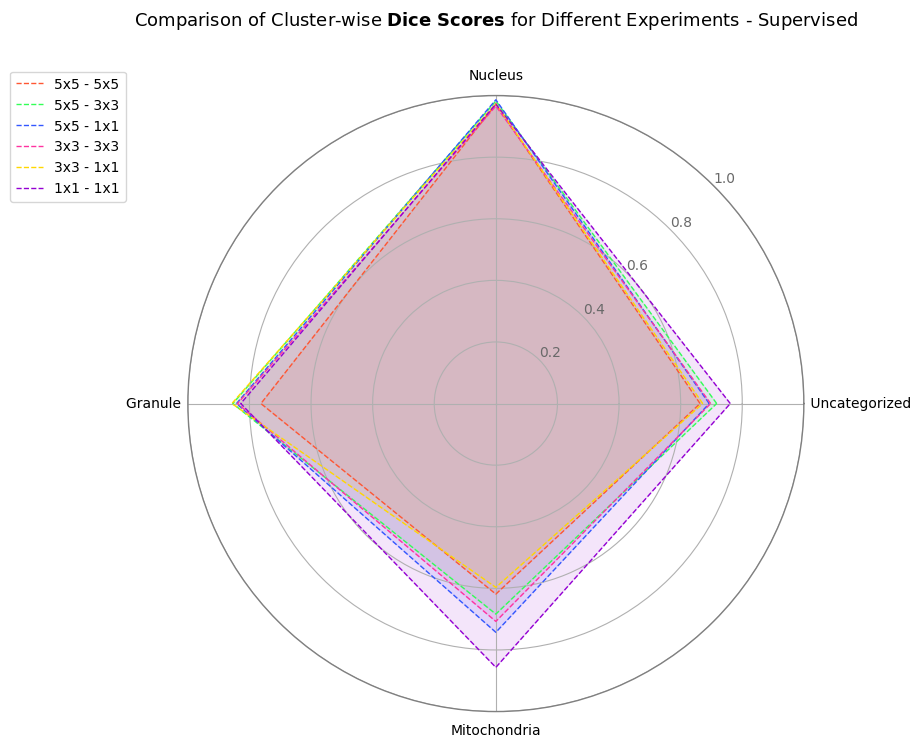

In [54]:
import matplotlib.pyplot as plt
from math import pi

color_list = [
    '#FF5733',  # Vivid Orange-Red
    '#33FF57',  # Bright Green
    '#3357FF',  # Bright Blue
    '#FF33A1',  # Vivid Pink
    '#FFD700',  # Bright Yellow
    '#9400D3'   # Dark Violet
]
# Function to create radar charts for multiple experiments
def radar_chart(experiments_data, classes, experiment_labels):
    # Number of variables (classes in this case)
    num_vars = len(classes)

    # Compute angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each experiment's scores
    for i, experiment_scores in enumerate(experiments_data):
        data = experiment_scores + experiment_scores[:1]  # Complete the loop
        ax.plot(angles, data, linewidth=1, linestyle='dashed', color=color_list[i], label=experiment_labels[i])
        ax.fill(angles, data, color=color_list[i], alpha=0.1)

    # Add the class names as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)


    # Set the range and labels for the radial grid
    ax.set_rlabel_position(45)  # Position the radial labels at 45 degrees
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Define where the radial ticks appear
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10, color='#696969' )  # Define the tick labels
    ax.set_ylim(0, 1)  # Ensure the plot goes from 0 to 1

    # Make the outer circle gray and adjust the gridlines color to gray
    ax.spines['polar'].set_visible(True)  # Make sure the outer spine is visible
    ax.spines['polar'].set_color('gray')  # Set the outer circle (spine) color to gray
    ax.spines['polar'].set_linewidth(1)   # Set the line width of the outer circle

    
    # Add a floating legend
    plt.legend(loc='upper left', bbox_to_anchor=(-0.3, 1.05))  # Move the legend outside the plot

    # Remove plt.title and use ax.text for full customization
    plt.title(r'Comparison of Cluster-wise $\mathbf{Dice\ Scores}$ for Different Experiments - Supervised', 
          size=13, color='black', y=1.1)


    # Show the plot
    plt.show()

# Example data
classes = ['                 Uncategorized', 'Nucleus', 'Granule       ', 'Mitochondria']
experiments_data = [
    [0.6630872483221476, 0.9718875502008032, 0.7627906976744186, 0.6186666666666667],
    [0.717037037037037, 0.9821782178217822, 0.854122621564482, 0.6835443037974683],
    [0.6926829268292682, 0.9863013698630136, 0.8421052631578947, 0.7427293064876958],
    [0.6973293768545994, 0.9659318637274549, 0.8387096774193549, 0.7073170731707317],
    [0.6715542521994134, 0.9740518962075848, 0.8571428571428571, 0.5968586387434555],
    [0.7610921501706485, 0.9724409448818898, 0.8283261802575107, 0.8565573770491803],
]
experiment_labels = ['5x5 - 5x5', '5x5 - 3x3', '5x5 - 1x1', '3x3 - 3x3', '3x3 - 1x1', '1x1 - 1x1']

# Create the radar chart
radar_chart(experiments_data, classes, experiment_labels)


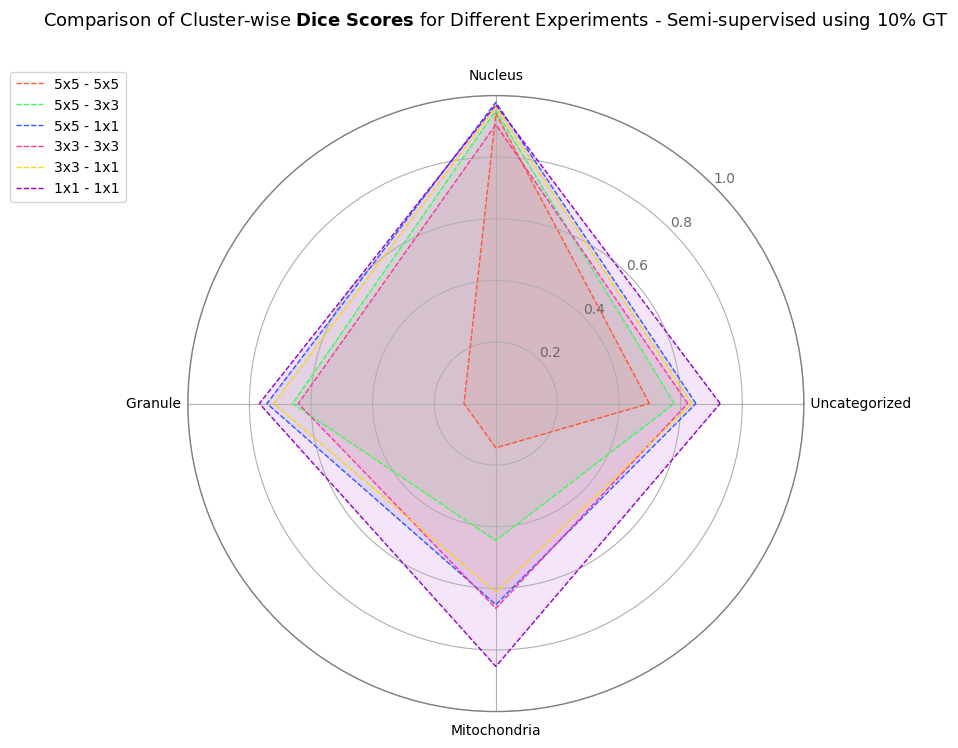

In [55]:
import matplotlib.pyplot as plt
from math import pi

color_list = [
    '#FF5733',  # Vivid Orange-Red
    '#33FF57',  # Bright Green
    '#3357FF',  # Bright Blue
    '#FF33A1',  # Vivid Pink
    '#FFD700',  # Bright Yellow
    '#9400D3'   # Dark Violet
]
# Function to create radar charts for multiple experiments
def radar_chart(experiments_data, classes, experiment_labels):
    # Number of variables (classes in this case)
    num_vars = len(classes)

    # Compute angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each experiment's scores
    for i, experiment_scores in enumerate(experiments_data):
        data = experiment_scores + experiment_scores[:1]  # Complete the loop
        ax.plot(angles, data, linewidth=1, linestyle='dashed', color=color_list[i], label=experiment_labels[i])
        ax.fill(angles, data, color=color_list[i], alpha=0.1)

    # Add the class names as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)


    # Set the range and labels for the radial grid
    ax.set_rlabel_position(45)  # Position the radial labels at 45 degrees
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Define where the radial ticks appear
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10, color='#696969' )  # Define the tick labels
    ax.set_ylim(0, 1)  # Ensure the plot goes from 0 to 1

    # Make the outer circle gray and adjust the gridlines color to gray
    ax.spines['polar'].set_visible(True)  # Make sure the outer spine is visible
    ax.spines['polar'].set_color('gray')  # Set the outer circle (spine) color to gray
    ax.spines['polar'].set_linewidth(1)   # Set the line width of the outer circle

    
    # Add a floating legend
    plt.legend(loc='upper left', bbox_to_anchor=(-0.3, 1.05))  # Move the legend outside the plot

    # Remove plt.title and use ax.text for full customization
    plt.title(r'Comparison of Cluster-wise $\mathbf{Dice\ Scores}$ for Different Experiments - Semi-supervised using 10% GT', 
          size=13, color='black', y=1.1)


    # Show the plot
    plt.show()

# Example data
classes = ['                 Uncategorized', 'Nucleus', 'Granule       ', 'Mitochondria']
experiments_data = [
    [0.49852216748768474, 0.9421487603305785, 0.1033210332103321, 0.14388489208633093],
    [0.5794621026894865, 0.9510204081632653, 0.6600496277915633, 0.44510385756676557],
    [0.6497175141242938, 0.9783037475345168, 0.7432432432432432, 0.6529562982005142],
    [0.6226175349428208, 0.905982905982906, 0.6414141414141414, 0.6649874055415617],
    [0.6364883401920439, 0.9635627530364372, 0.7213114754098361, 0.6130653266331658],
    [0.728171334431631, 0.9700598802395209, 0.7678571428571429, 0.8536585365853658],
]
experiment_labels = ['5x5 - 5x5', '5x5 - 3x3', '5x5 - 1x1', '3x3 - 3x3', '3x3 - 1x1', '1x1 - 1x1']

# Create the radar chart
radar_chart(experiments_data, classes, experiment_labels)


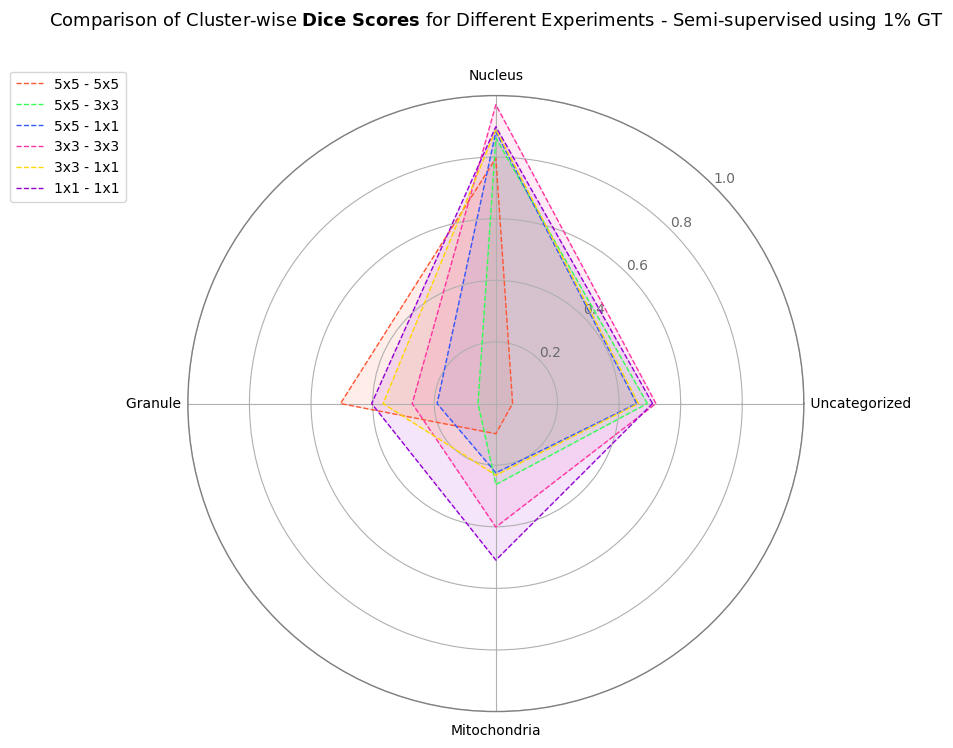

In [44]:
import matplotlib.pyplot as plt
from math import pi

color_list = [
    '#FF5733',  # Vivid Orange-Red
    '#33FF57',  # Bright Green
    '#3357FF',  # Bright Blue
    '#FF33A1',  # Vivid Pink
    '#FFD700',  # Bright Yellow
    '#9400D3'   # Dark Violet
]
# Function to create radar charts for multiple experiments
def radar_chart(experiments_data, classes, experiment_labels):
    # Number of variables (classes in this case)
    num_vars = len(classes)

    # Compute angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each experiment's scores
    for i, experiment_scores in enumerate(experiments_data):
        data = experiment_scores + experiment_scores[:1]  # Complete the loop
        ax.plot(angles, data, linewidth=1, linestyle='dashed', color=color_list[i], label=experiment_labels[i])
        ax.fill(angles, data, color=color_list[i], alpha=0.1)

    # Add the class names as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)


    # Set the range and labels for the radial grid
    ax.set_rlabel_position(45)  # Position the radial labels at 45 degrees
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Define where the radial ticks appear
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10, color='#696969' )  # Define the tick labels
    ax.set_ylim(0, 1)  # Ensure the plot goes from 0 to 1

    # Make the outer circle gray and adjust the gridlines color to gray
    ax.spines['polar'].set_visible(True)  # Make sure the outer spine is visible
    ax.spines['polar'].set_color('gray')  # Set the outer circle (spine) color to gray
    ax.spines['polar'].set_linewidth(1)   # Set the line width of the outer circle

    
    # Add a floating legend
    plt.legend(loc='upper left', bbox_to_anchor=(-0.3, 1.05))  # Move the legend outside the plot

    # Remove plt.title and use ax.text for full customization
    plt.title(r'Comparison of Cluster-wise $\mathbf{Dice\ Scores}$ for Different Experiments - Semi-supervised using 1% GT', 
          size=13, color='black', y=1.1)


    # Show the plot
    plt.show()

# Example data
classes = ['                 Uncategorized', 'Nucleus', 'Granule       ', 'Mitochondria']
experiments_data = [
    [0.05442176870748299, 0.7963386727688787, 0.5044510385756676, 0.09803921568627451],
    [0.49183673469387756, 0.8622222222222222, 0.057971014492753624, 0.2631578947368421],
    [0.45720984759671746, 0.8820960698689956, 0.1907514450867052, 0.22506393861892582],
    [0.519774011299435, 0.9702970297029703, 0.2716049382716049, 0.40119760479041916],
    [0.4629156010230179, 0.8898488120950324, 0.3660130718954248, 0.23255813953488372],
    [0.508843537414966, 0.8989247311827957, 0.40329218106995884, 0.5082872928176796],
]
experiment_labels = ['5x5 - 5x5', '5x5 - 3x3', '5x5 - 1x1', '3x3 - 3x3', '3x3 - 1x1', '1x1 - 1x1']

# Create the radar chart
radar_chart(experiments_data, classes, experiment_labels)


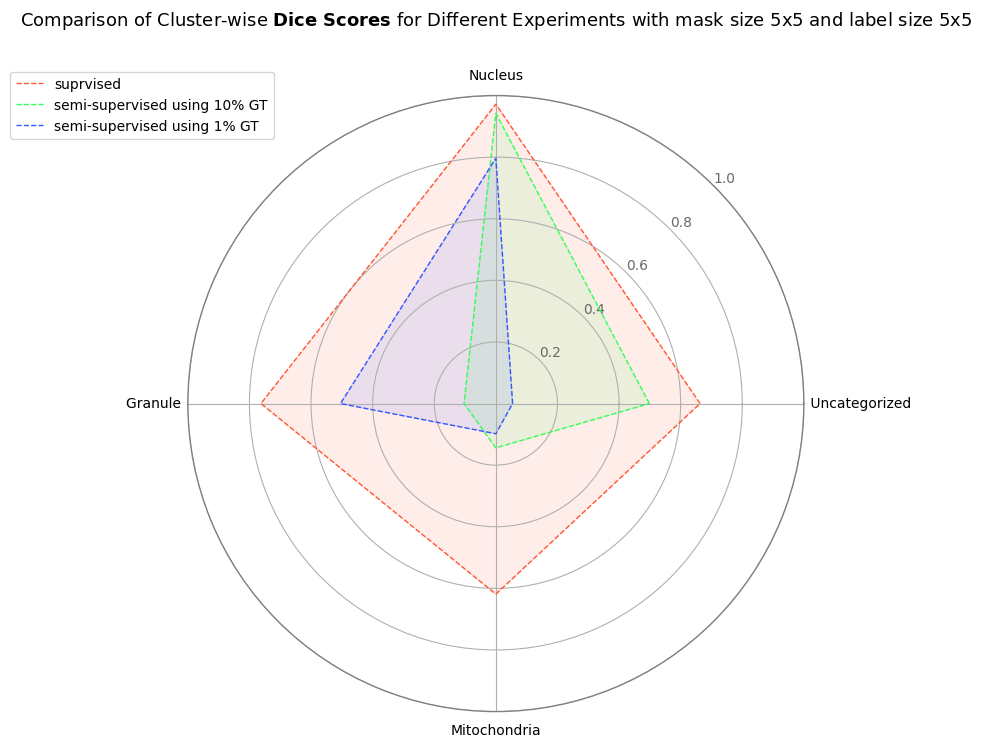

In [46]:
import matplotlib.pyplot as plt
from math import pi

color_list = [
    '#FF5733',  # Vivid Orange-Red
    '#33FF57',  # Bright Green
    '#3357FF',  # Bright Blue
]
# Function to create radar charts for multiple experiments
def radar_chart(experiments_data, classes, experiment_labels):
    # Number of variables (classes in this case)
    num_vars = len(classes)

    # Compute angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each experiment's scores
    for i, experiment_scores in enumerate(experiments_data):
        data = experiment_scores + experiment_scores[:1]  # Complete the loop
        ax.plot(angles, data, linewidth=1, linestyle='dashed', color=color_list[i], label=experiment_labels[i])
        ax.fill(angles, data, color=color_list[i], alpha=0.1)

    # Add the class names as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)


    # Set the range and labels for the radial grid
    ax.set_rlabel_position(45)  # Position the radial labels at 45 degrees
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Define where the radial ticks appear
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10, color='#696969' )  # Define the tick labels
    ax.set_ylim(0, 1)  # Ensure the plot goes from 0 to 1

    # Make the outer circle gray and adjust the gridlines color to gray
    ax.spines['polar'].set_visible(True)  # Make sure the outer spine is visible
    ax.spines['polar'].set_color('gray')  # Set the outer circle (spine) color to gray
    ax.spines['polar'].set_linewidth(1)   # Set the line width of the outer circle

    
    # Add a floating legend
    plt.legend(loc='upper left', bbox_to_anchor=(-0.3, 1.05))  # Move the legend outside the plot

    # Remove plt.title and use ax.text for full customization
    plt.title(r'Comparison of Cluster-wise $\mathbf{Dice\ Scores}$ for Different Experiments with mask size 5x5 and label size 5x5', 
          size=13, color='black', y=1.1)


    # Show the plot
    plt.show()

# Example data
classes = ['                 Uncategorized', 'Nucleus', 'Granule       ', 'Mitochondria']
experiments_data = [
    [0.6630872483221476, 0.9718875502008032, 0.7627906976744186, 0.6186666666666667],
    [0.49852216748768474, 0.9421487603305785, 0.1033210332103321, 0.14388489208633093],
    [0.05442176870748299, 0.7963386727688787, 0.5044510385756676, 0.09803921568627451]
]
ten_percent = 10
one_percent = 1
experiment_labels = ['suprvised', f'semi-supervised using {ten_percent}% GT', f'semi-supervised using {one_percent}% GT']

# Create the radar chart
radar_chart(experiments_data, classes, experiment_labels)


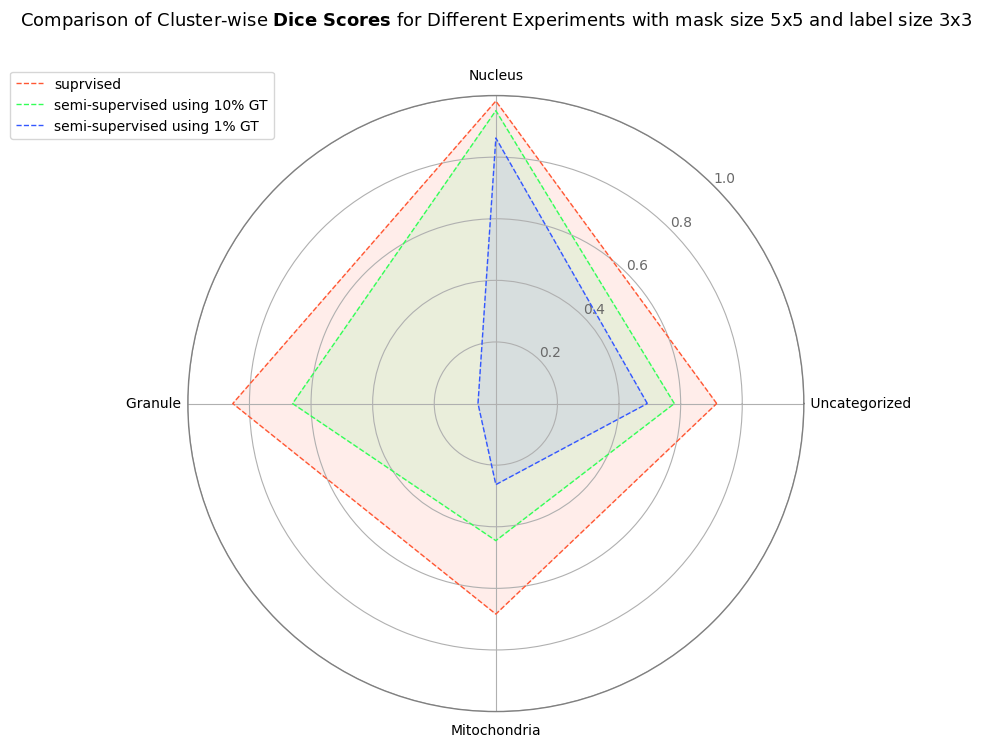

In [47]:
import matplotlib.pyplot as plt
from math import pi

color_list = [
    '#FF5733',  # Vivid Orange-Red
    '#33FF57',  # Bright Green
    '#3357FF',  # Bright Blue
]
# Function to create radar charts for multiple experiments
def radar_chart(experiments_data, classes, experiment_labels):
    # Number of variables (classes in this case)
    num_vars = len(classes)

    # Compute angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each experiment's scores
    for i, experiment_scores in enumerate(experiments_data):
        data = experiment_scores + experiment_scores[:1]  # Complete the loop
        ax.plot(angles, data, linewidth=1, linestyle='dashed', color=color_list[i], label=experiment_labels[i])
        ax.fill(angles, data, color=color_list[i], alpha=0.1)

    # Add the class names as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)


    # Set the range and labels for the radial grid
    ax.set_rlabel_position(45)  # Position the radial labels at 45 degrees
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Define where the radial ticks appear
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10, color='#696969' )  # Define the tick labels
    ax.set_ylim(0, 1)  # Ensure the plot goes from 0 to 1

    # Make the outer circle gray and adjust the gridlines color to gray
    ax.spines['polar'].set_visible(True)  # Make sure the outer spine is visible
    ax.spines['polar'].set_color('gray')  # Set the outer circle (spine) color to gray
    ax.spines['polar'].set_linewidth(1)   # Set the line width of the outer circle

    
    # Add a floating legend
    plt.legend(loc='upper left', bbox_to_anchor=(-0.3, 1.05))  # Move the legend outside the plot

    # Remove plt.title and use ax.text for full customization
    plt.title(r'Comparison of Cluster-wise $\mathbf{Dice\ Scores}$ for Different Experiments with mask size 5x5 and label size 3x3', 
          size=13, color='black', y=1.1)


    # Show the plot
    plt.show()

# Example data
classes = ['                 Uncategorized', 'Nucleus', 'Granule       ', 'Mitochondria']
experiments_data = [
    [0.717037037037037, 0.9821782178217822, 0.854122621564482, 0.6835443037974683],
    [0.5794621026894865, 0.9510204081632653, 0.6600496277915633, 0.44510385756676557],
    [0.49183673469387756, 0.8622222222222222, 0.057971014492753624, 0.2631578947368421]
]
ten_percent = 10
one_percent = 1
experiment_labels = ['suprvised', f'semi-supervised using {ten_percent}% GT', f'semi-supervised using {one_percent}% GT']

# Create the radar chart
radar_chart(experiments_data, classes, experiment_labels)


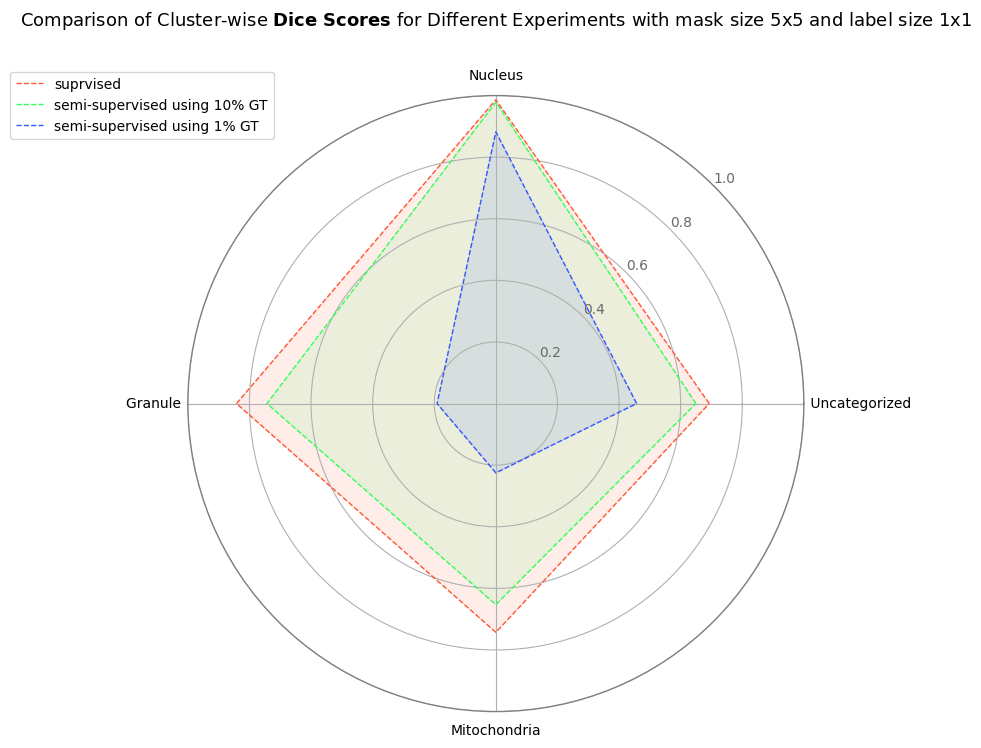

In [48]:
import matplotlib.pyplot as plt
from math import pi

color_list = [
    '#FF5733',  # Vivid Orange-Red
    '#33FF57',  # Bright Green
    '#3357FF',  # Bright Blue
]
# Function to create radar charts for multiple experiments
def radar_chart(experiments_data, classes, experiment_labels):
    # Number of variables (classes in this case)
    num_vars = len(classes)

    # Compute angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each experiment's scores
    for i, experiment_scores in enumerate(experiments_data):
        data = experiment_scores + experiment_scores[:1]  # Complete the loop
        ax.plot(angles, data, linewidth=1, linestyle='dashed', color=color_list[i], label=experiment_labels[i])
        ax.fill(angles, data, color=color_list[i], alpha=0.1)

    # Add the class names as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)


    # Set the range and labels for the radial grid
    ax.set_rlabel_position(45)  # Position the radial labels at 45 degrees
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Define where the radial ticks appear
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10, color='#696969' )  # Define the tick labels
    ax.set_ylim(0, 1)  # Ensure the plot goes from 0 to 1

    # Make the outer circle gray and adjust the gridlines color to gray
    ax.spines['polar'].set_visible(True)  # Make sure the outer spine is visible
    ax.spines['polar'].set_color('gray')  # Set the outer circle (spine) color to gray
    ax.spines['polar'].set_linewidth(1)   # Set the line width of the outer circle

    
    # Add a floating legend
    plt.legend(loc='upper left', bbox_to_anchor=(-0.3, 1.05))  # Move the legend outside the plot

    # Remove plt.title and use ax.text for full customization
    plt.title(r'Comparison of Cluster-wise $\mathbf{Dice\ Scores}$ for Different Experiments with mask size 5x5 and label size 1x1', 
          size=13, color='black', y=1.1)


    # Show the plot
    plt.show()

# Example data
classes = ['                 Uncategorized', 'Nucleus', 'Granule       ', 'Mitochondria']
experiments_data = [
    [0.6926829268292682, 0.9863013698630136, 0.8421052631578947, 0.7427293064876958],
    [0.6497175141242938, 0.9783037475345168, 0.7432432432432432, 0.6529562982005142],
    [0.45720984759671746, 0.8820960698689956, 0.1907514450867052, 0.22506393861892582]
]
ten_percent = 10
one_percent = 1
experiment_labels = ['suprvised', f'semi-supervised using {ten_percent}% GT', f'semi-supervised using {one_percent}% GT']

# Create the radar chart
radar_chart(experiments_data, classes, experiment_labels)


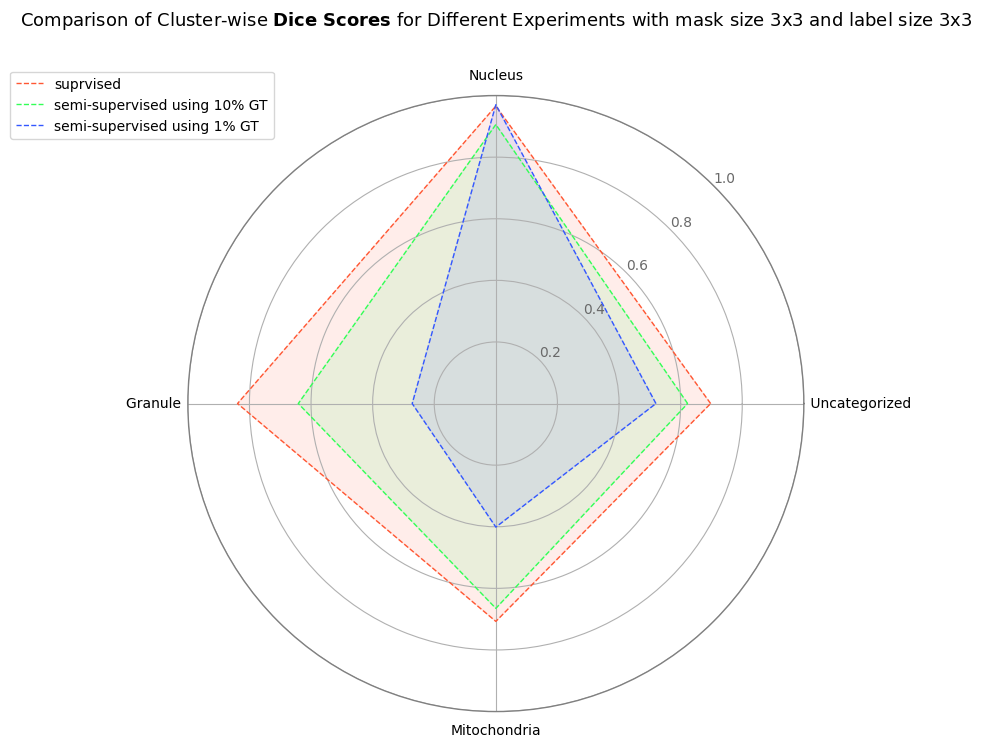

In [49]:
import matplotlib.pyplot as plt
from math import pi

color_list = [
    '#FF5733',  # Vivid Orange-Red
    '#33FF57',  # Bright Green
    '#3357FF',  # Bright Blue
]
# Function to create radar charts for multiple experiments
def radar_chart(experiments_data, classes, experiment_labels):
    # Number of variables (classes in this case)
    num_vars = len(classes)

    # Compute angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each experiment's scores
    for i, experiment_scores in enumerate(experiments_data):
        data = experiment_scores + experiment_scores[:1]  # Complete the loop
        ax.plot(angles, data, linewidth=1, linestyle='dashed', color=color_list[i], label=experiment_labels[i])
        ax.fill(angles, data, color=color_list[i], alpha=0.1)

    # Add the class names as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)


    # Set the range and labels for the radial grid
    ax.set_rlabel_position(45)  # Position the radial labels at 45 degrees
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Define where the radial ticks appear
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10, color='#696969' )  # Define the tick labels
    ax.set_ylim(0, 1)  # Ensure the plot goes from 0 to 1

    # Make the outer circle gray and adjust the gridlines color to gray
    ax.spines['polar'].set_visible(True)  # Make sure the outer spine is visible
    ax.spines['polar'].set_color('gray')  # Set the outer circle (spine) color to gray
    ax.spines['polar'].set_linewidth(1)   # Set the line width of the outer circle

    
    # Add a floating legend
    plt.legend(loc='upper left', bbox_to_anchor=(-0.3, 1.05))  # Move the legend outside the plot

    # Remove plt.title and use ax.text for full customization
    plt.title(r'Comparison of Cluster-wise $\mathbf{Dice\ Scores}$ for Different Experiments with mask size 3x3 and label size 3x3', 
          size=13, color='black', y=1.1)


    # Show the plot
    plt.show()

# Example data
classes = ['                 Uncategorized', 'Nucleus', 'Granule       ', 'Mitochondria']
experiments_data = [
[0.6973293768545994, 0.9659318637274549, 0.8387096774193549, 0.7073170731707317],
[0.6226175349428208, 0.905982905982906, 0.6414141414141414, 0.6649874055415617],
[0.519774011299435, 0.9702970297029703, 0.2716049382716049, 0.40119760479041916]
]
ten_percent = 10
one_percent = 1
experiment_labels = ['suprvised', f'semi-supervised using {ten_percent}% GT', f'semi-supervised using {one_percent}% GT']

# Create the radar chart
radar_chart(experiments_data, classes, experiment_labels)


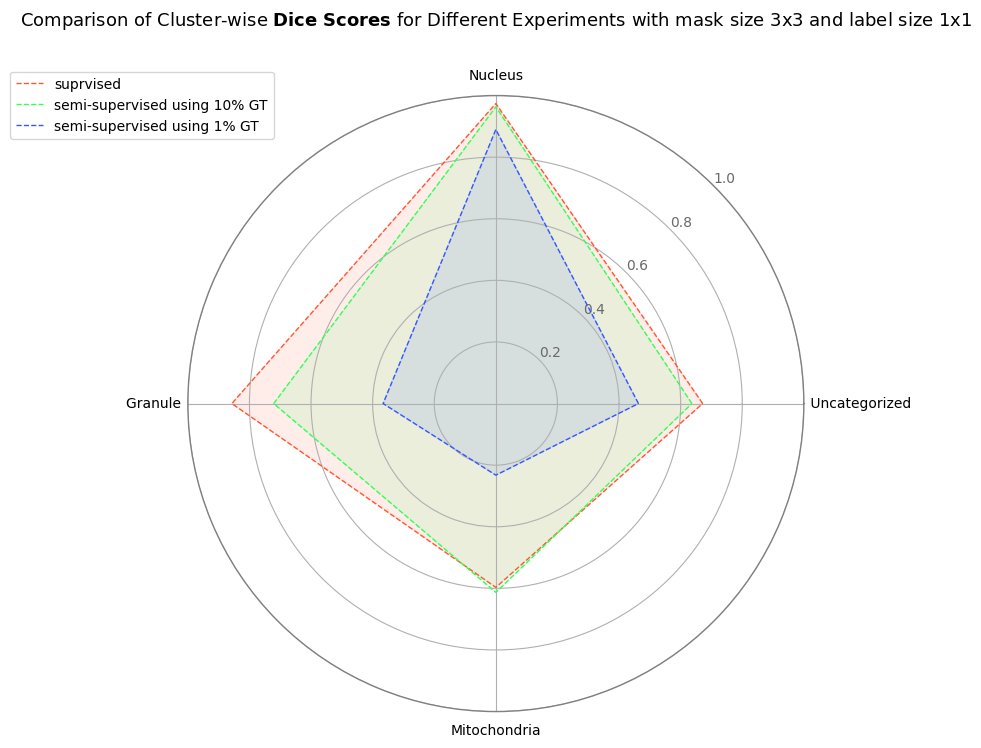

In [50]:
import matplotlib.pyplot as plt
from math import pi

color_list = [
    '#FF5733',  # Vivid Orange-Red
    '#33FF57',  # Bright Green
    '#3357FF',  # Bright Blue
]
# Function to create radar charts for multiple experiments
def radar_chart(experiments_data, classes, experiment_labels):
    # Number of variables (classes in this case)
    num_vars = len(classes)

    # Compute angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each experiment's scores
    for i, experiment_scores in enumerate(experiments_data):
        data = experiment_scores + experiment_scores[:1]  # Complete the loop
        ax.plot(angles, data, linewidth=1, linestyle='dashed', color=color_list[i], label=experiment_labels[i])
        ax.fill(angles, data, color=color_list[i], alpha=0.1)

    # Add the class names as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)


    # Set the range and labels for the radial grid
    ax.set_rlabel_position(45)  # Position the radial labels at 45 degrees
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Define where the radial ticks appear
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10, color='#696969' )  # Define the tick labels
    ax.set_ylim(0, 1)  # Ensure the plot goes from 0 to 1

    # Make the outer circle gray and adjust the gridlines color to gray
    ax.spines['polar'].set_visible(True)  # Make sure the outer spine is visible
    ax.spines['polar'].set_color('gray')  # Set the outer circle (spine) color to gray
    ax.spines['polar'].set_linewidth(1)   # Set the line width of the outer circle

    
    # Add a floating legend
    plt.legend(loc='upper left', bbox_to_anchor=(-0.3, 1.05))  # Move the legend outside the plot

    # Remove plt.title and use ax.text for full customization
    plt.title(r'Comparison of Cluster-wise $\mathbf{Dice\ Scores}$ for Different Experiments with mask size 3x3 and label size 1x1', 
          size=13, color='black', y=1.1)


    # Show the plot
    plt.show()

# Example data
classes = ['                 Uncategorized', 'Nucleus', 'Granule       ', 'Mitochondria']
experiments_data = [
[0.6715542521994134, 0.9740518962075848, 0.8571428571428571, 0.5968586387434555],
[0.6364883401920439, 0.9635627530364372, 0.7213114754098361, 0.6130653266331658],
[0.4629156010230179, 0.8898488120950324, 0.3660130718954248, 0.23255813953488372]
]
ten_percent = 10
one_percent = 1
experiment_labels = ['suprvised', f'semi-supervised using {ten_percent}% GT', f'semi-supervised using {one_percent}% GT']

# Create the radar chart
radar_chart(experiments_data, classes, experiment_labels)


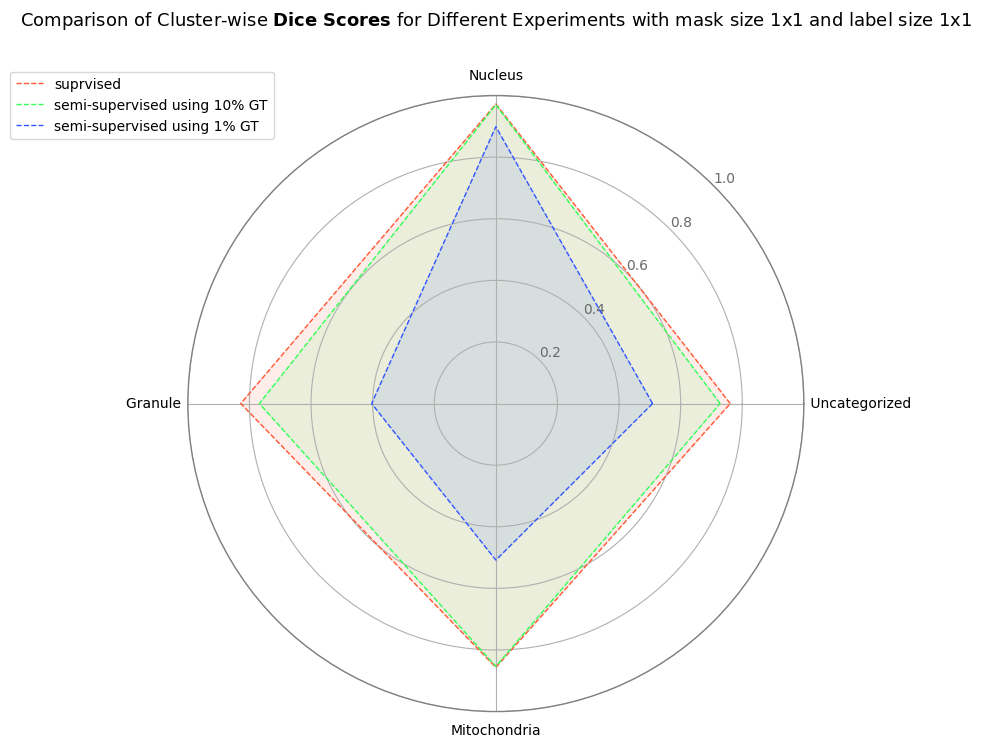

In [51]:
import matplotlib.pyplot as plt
from math import pi

color_list = [
    '#FF5733',  # Vivid Orange-Red
    '#33FF57',  # Bright Green
    '#3357FF',  # Bright Blue
]
# Function to create radar charts for multiple experiments
def radar_chart(experiments_data, classes, experiment_labels):
    # Number of variables (classes in this case)
    num_vars = len(classes)

    # Compute angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each experiment's scores
    for i, experiment_scores in enumerate(experiments_data):
        data = experiment_scores + experiment_scores[:1]  # Complete the loop
        ax.plot(angles, data, linewidth=1, linestyle='dashed', color=color_list[i], label=experiment_labels[i])
        ax.fill(angles, data, color=color_list[i], alpha=0.1)

    # Add the class names as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)


    # Set the range and labels for the radial grid
    ax.set_rlabel_position(45)  # Position the radial labels at 45 degrees
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Define where the radial ticks appear
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10, color='#696969' )  # Define the tick labels
    ax.set_ylim(0, 1)  # Ensure the plot goes from 0 to 1

    # Make the outer circle gray and adjust the gridlines color to gray
    ax.spines['polar'].set_visible(True)  # Make sure the outer spine is visible
    ax.spines['polar'].set_color('gray')  # Set the outer circle (spine) color to gray
    ax.spines['polar'].set_linewidth(1)   # Set the line width of the outer circle

    
    # Add a floating legend
    plt.legend(loc='upper left', bbox_to_anchor=(-0.3, 1.05))  # Move the legend outside the plot

    # Remove plt.title and use ax.text for full customization
    plt.title(r'Comparison of Cluster-wise $\mathbf{Dice\ Scores}$ for Different Experiments with mask size 1x1 and label size 1x1', 
          size=13, color='black', y=1.1)


    # Show the plot
    plt.show()

# Example data
classes = ['                 Uncategorized', 'Nucleus', 'Granule       ', 'Mitochondria']
experiments_data = [
[0.7610921501706485, 0.9724409448818898, 0.8283261802575107, 0.8565573770491803],
[0.728171334431631, 0.9700598802395209, 0.7678571428571429, 0.8536585365853658],
[0.508843537414966, 0.8989247311827957, 0.40329218106995884, 0.5082872928176796]
]
ten_percent = 10
one_percent = 1
experiment_labels = ['suprvised', f'semi-supervised using {ten_percent}% GT', f'semi-supervised using {one_percent}% GT']

# Create the radar chart
radar_chart(experiments_data, classes, experiment_labels)
